In [27]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd

import shutil
import sys
import os.path

if not shutil.which("pyomo"):
    !pip install -q pyomo
    assert(shutil.which("pyomo"))

if not (shutil.which("cbc") or os.path.isfile("cbc")):
    if "google.colab" in sys.modules:
        !apt-get install -y -qq coinor-cbc
    else:
        try:
            !conda install -c conda-forge coincbc 
        except:
            pass

assert(shutil.which("cbc") or os.path.isfile("cbc"))

import pyomo.environ as pyomo

In [28]:
os.path.isfile("cbc"),shutil.which("cbc")

(True, '/home/aaron/anaconda3/bin/cbc')

In [29]:
data = {
    'A': {'abv': 0.045, 'cost': 0.32},
    'B': {'abv': 0.037, 'cost': 0.25},
    'W': {'abv': 0.000, 'cost': 0.05},
}

In [40]:
sys.path

['/home/aaron/Desktop/VOIC',
 '/home/aaron/anaconda3/lib/python311.zip',
 '/home/aaron/anaconda3/lib/python3.11',
 '/home/aaron/anaconda3/lib/python3.11/lib-dynload',
 '',
 '/home/aaron/anaconda3/lib/python3.11/site-packages',
 '/home/aaron/anaconda3/bin/',
 '/home/aaron/anaconda3/bin/']

In [39]:
vol = 100
abv = 0.040

solvername='cbc'
solverpath='/home/aaron/Desktop/VOIC/cbc'
solverpath_folder='/home/aaron/anaconda3/bin/'

sys.path.append(solverpath_folder)

def beer_blend(vol, abv, data):
    C = data.keys()
    model = pyomo.ConcreteModel()
    model.x = pyomo.Var(C, domain=pyomo.NonNegativeReals)
    model.cost = pyomo.Objective(expr = sum(model.x[c]*data[c]['cost'] for c in C))
    model.vol = pyomo.Constraint(expr = vol == sum(model.x[c] for c in C))
    model.abv = pyomo.Constraint(
        expr = 0 == sum(model.x[c]*(data[c]['abv'] - abv) for c in C))

    solver = pyomo.SolverFactory(solvername,executable=solverpath)
    # solver = pyomo.SolverFactory('cbc')
    solver.solve(model,tee=True,keepfiles=True)

    print('Optimal Blend')
    for c in data.keys():
        print('  ', c, ':', model.x[c](), 'gallons')
    print()
    print('Volume = ', model.vol(), 'gallons')
    print('Cost = $', model.cost())
    
beer_blend(vol, abv, data)

Solver log file: '/tmp/tmpwywuxqh0.cbc.log'
Solver solution file: '/tmp/tmpcvhgujyh.pyomo.soln'
Solver problem files: ('/tmp/tmpcvhgujyh.pyomo.lp',)
Welcome to the CBC MILP Solver 
Version: 2.10.3 
Build Date: Mar 24 2020 

command line - /home/aaron/Desktop/VOIC/cbc -printingOptions all -import /tmp/tmpcvhgujyh.pyomo.lp -stat=1 -solve -solu /tmp/tmpcvhgujyh.pyomo.soln (default strategy 1)
Option for printingOptions changed from normal to all
Presolve 0 (-2) rows, 0 (-3) columns and 0 (-6) elements
Statistics for presolved model


Problem has 0 rows, 0 columns (0 with objective) and 0 elements
There are 22088 singletons with no objective 
Column breakdown:
0 of type 0.0->inf, 0 of type 0.0->up, 0 of type lo->inf, 
0 of type lo->up, 0 of type free, 0 of type fixed, 
0 of type -inf->0.0, 0 of type -inf->up, 0 of type 0.0->1.0 
Row breakdown:
0 of type E 0.0, 0 of type E 1.0, 0 of type E -1.0, 
0 of type E other, 0 of type G 0.0, 0 of type G 1.0, 
0 of type G other, 0 of type L 0.0, 0 of 

Text(0.5, 1.0, 'Demand')

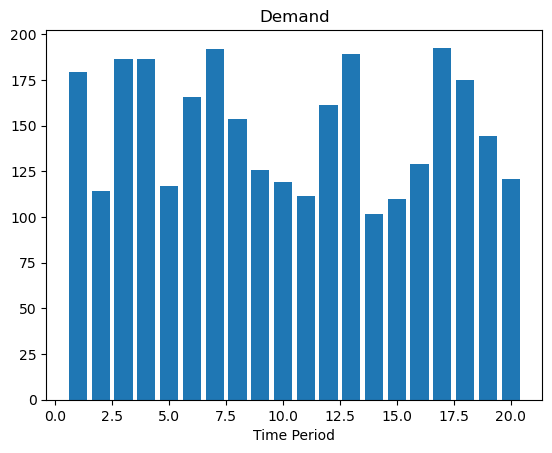

In [35]:
# demand
T = 20
T = np.array([t for t in range(0, T)])
d = np.array([100 + 100*np.random.uniform() for t in T])

fig, ax = plt.subplots(1,1)
ax.bar(T+1, d)
ax.set_xlabel('Time Period')
ax.set_title('Demand')

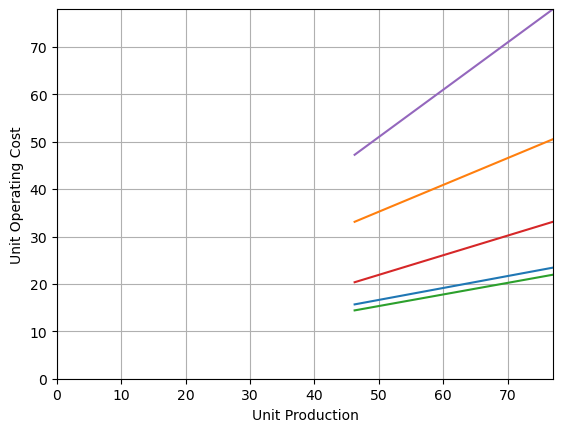

In [36]:
# generating units
N = 5
pmax = 2*max(d)/N
pmin = 0.6*pmax

N = np.array([n for n in range(0, N)])
a = np.array([0.5 + 0.2*np.random.randn() for n in N])
b = np.array([10*np.random.uniform() for n in N])

p = np.linspace(pmin, pmax)

fig, ax = plt.subplots(1,1)
for n in N:
    ax.plot(p, a[n]*p + b[n])
ax.set_xlim(0, pmax)
ax.set_ylim(0, max(a*pmax + b))
ax.set_xlabel('Unit Production')
ax.set_ylabel('Unit Operating Cost')
ax.grid()

In [43]:
# import pyomo.environ as pyo
import pyomo.gdp as gdp

def unit_commitment():
    m = pyomo.ConcreteModel()

    m.N = pyomo.Set(initialize=N)
    m.T = pyomo.Set(initialize=T)

    m.x = pyomo.Var(m.N, m.T, bounds = (0, pmax))
    m.u = pyomo.Var(m.N, m.T, domain=pyo.Binary)
    
    # objective
    m.cost = pyomo.Objective(expr = sum(m.x[n,t]*a[n] * m.u[n,t]*b[n] for t in m.T for n in m.N), sense=pyo.minimize)
    
    # demand
    m.demand = pyomo.Constraint(m.T, rule=lambda m, t: sum(m.x[n,t] for n in N) == d[t])
    
    # semi-continuous
    m.lb = pyomo.Constraint(m.N, m.T, rule=lambda m, n, t: pmin*m.u[n,t] <= m.x[n,t])
    m.ub = pyomo.Constraint(m.N, m.T, rule=lambda m, n, t: pmax*m.u[n,t] >= m.x[n,t])
    return m
   
m = unit_commitment()
# pyo.SolverFactory('glpk').solve(m).write()

solver=pyomo.SolverFactory('bonmin')
# solver = pyomo.SolverFactory(solvername,executable=solverpath)
solver.solve(m,tee=True,keepfiles=True).write()

fig, ax = plt.subplots(max(N)+1, 1, figsize=(8, 1.5*max(N)+1))
for n in N:
    ax[n].bar(T+1, [m.x[n,t]() for t in T])
    ax[n].set_xlim(0, max(T)+2)
    ax[n].set_ylim(0, 1.1*pmax)
    ax[n].plot(ax[n].get_xlim(), np.array([pmax, pmax]), 'r--')
    ax[n].plot(ax[n].get_xlim(), np.array([pmin, pmin]), 'r--')
    ax[n].set_title('Unit ' + str(n+1))
fig.tight_layout()

for solver asl. File with name=bonmin either does not exist or it is not
executable. To skip this validation, call set_executable with validate=False.
Traceback (most recent call last):
  File "/home/aaron/anaconda3/lib/python3.11/site-packages/pyomo/opt/base/solvers.py", line 165, in __call__
    opt = self._cls[_implicit_solvers[mode]](**kwds)
          ^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^^
  File "/home/aaron/anaconda3/lib/python3.11/site-packages/pyomo/solvers/plugins/solvers/ASL.py", line 45, in __init__
    SystemCallSolver.__init__(self, **kwds)
  File "/home/aaron/anaconda3/lib/python3.11/site-packages/pyomo/opt/solver/shellcmd.py", line 67, in __init__
    self.set_executable(name=executable, validate=validate)
  File "/home/aaron/anaconda3/lib/python3.11/site-packages/pyomo/opt/solver/shellcmd.py", line 116, in set_executable
    raise ValueError(
ValueError: Failed to set executable for solver asl. File with name=bonmin either does not exist or it is not executable. To 

RuntimeError: Attempting to use an unavailable solver.

The SolverFactory was unable to create the solver "bonmin"
and returned an UnknownSolver object.  This error is raised at the point
where the UnknownSolver object was used as if it were valid (by calling
method "solve").

The original solver was created with the following parameters:
	executable: bonmin
	type: bonmin
	_args: ()
	options: {}

In [41]:
from mip import Model, xsum, maximize, BINARY

p = [10, 13, 18, 31, 7, 15]
w = [11, 15, 20, 35, 10, 33]
c, I = 47, range(len(w))

m = Model("knapsack")

x = [m.add_var(var_type=BINARY) for i in I]

m.objective = maximize(xsum(p[i] * x[i] for i in I))

m += xsum(w[i] * x[i] for i in I) <= c

m.optimize()

selected = [i for i in I if x[i].x >= 0.99]
print("selected items: {}".format(selected))

Welcome to the CBC MILP Solver 
Version: Trunk
Build Date: Oct 24 2021 

Starting solution of the Linear programming relaxation problem using Primal Simplex

Coin0506I Presolve 1 (0) rows, 6 (0) columns and 6 (0) elements
Clp1000I sum of infeasibilities 0 - average 0, 6 fixed columns
Coin0506I Presolve 0 (-1) rows, 0 (-6) columns and 0 (-6) elements
Clp0000I Optimal - objective value -0
Clp0000I Optimal - objective value -0
Coin0511I After Postsolve, objective 0, infeasibilities - dual 0 (0), primal 0 (0)
Clp0000I Optimal - objective value 42.171429
Clp0000I Optimal - objective value 42.171429
Clp0000I Optimal - objective value 42.171429
Clp0032I Optimal objective 42.17142857 - 0 iterations time 0.002, Idiot 0.00

Starting MIP optimization
selected items: [0, 3]
